## Handwritten digit recognition using deep learning with Tensorflow
### Edgar Acuna
### February 2022

In [74]:
# Imports
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [75]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [76]:
# Configuration options
feature_vector_length = 784
num_classes = 10

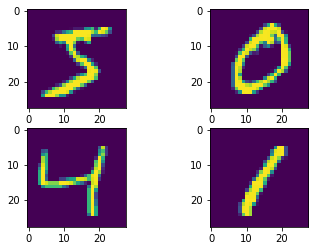

In [77]:
# normalize x
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
# we reserve the last 10000 training examples for validation
X_train, X_val = X_train[:-10000], X_train[-10000:]
Y_train, y_val = Y_train[:-10000], Y_train[-10000:]
# prepare image and figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(X_train[0])
ax2.imshow(X_train[1])
ax3.imshow(X_train[2])
ax4.imshow(X_train[3])

In [78]:
# Reshape the data - MLPs do not understand such things as '2D'.
# Reshape to 28 x 28 pixels = 784 features
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

In [79]:
# Convert target classes to categorical ones
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

Feature shape: (784,)


In [80]:
## Defining various initialization parameters for 784(Input)-512-256-10(Output) MLP model
num_classes = Y_train.shape[1]
num_features = X_train.shape[1]
num_output = Y_train.shape[1]
num_layers_0 = 512
num_layers_1 = 256
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [81]:
# Placeholders for the input data
tf.compat.v1.disable_eager_execution()
input_X = tf.compat.v1.placeholder('float32',shape =(None,num_features),name="input_X")
input_y = tf.compat.v1.placeholder('float32',shape = (None,num_classes),name='input_Y')
## for dropout layer
keep_prob = tf.compat.v1.placeholder(tf.float32)

In [82]:
## Weights initialized by random normal function with std_dev = 1/sqrt(number of input features)
weights_0 = tf.compat.v1.Variable(tf.compat.v1.random_normal([num_features,num_layers_0], stddev=(1/tf.sqrt(float(num_features)))))
bias_0 = tf.Variable(tf.compat.v1.random_normal([num_layers_0]))
weights_1 = tf.compat.v1.Variable(tf.compat.v1.random_normal([num_layers_0,num_layers_1], stddev=(1/tf.sqrt(float(num_layers_0)))))
bias_1 = tf.compat.v1.Variable(tf.compat.v1.random_normal([num_layers_1]))
weights_2 = tf.compat.v1.Variable(tf.compat.v1.random_normal([num_layers_1,num_output], stddev=(1/tf.sqrt(float(num_layers_1)))))
bias_2 = tf.compat.v1.Variable(tf.compat.v1.random_normal([num_output]))

In [83]:
## Initializing weigths and biases
hidden_output_0 = tf.compat.v1.nn.relu(tf.matmul(input_X,weights_0)+bias_0)
hidden_output_0_0 = tf.compat.v1.nn.dropout(hidden_output_0, keep_prob)
hidden_output_1 = tf.compat.v1.nn.relu(tf.matmul(hidden_output_0_0,weights_1)+bias_1)
hidden_output_1_1 = tf.compat.v1.nn.dropout(hidden_output_1, keep_prob)
predicted_y = tf.compat.v1.sigmoid(tf.matmul(hidden_output_1_1,weights_2) + bias_2)

In [84]:
## Defining the loss function
loss = tf.compat.v1.reduce_mean(tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y)) \
        + regularizer_rate*(tf.compat.v1.reduce_sum(tf.square(bias_0)) + tf.compat.v1.reduce_sum(tf.square(bias_1)))

In [85]:
# Variable learning rate
learning_rate = tf.compat.v1.train.exponential_decay(starter_learning_rate, 0, 5, 0.85, staircase=True)
## Adam optimzer for finding the right weight
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss,var_list=[weights_0,weights_1,weights_2,
                                                                         bias_0,bias_1,bias_2])

In [86]:
## Metrics definition
correct_prediction = tf.compat.v1.equal(tf.argmax(Y_train,1), tf.argmax(predicted_y,1))
accuracy = tf.compat.v1.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [87]:
## Training parameters
batch_size = 128
epochs=15
dropout_prob = 0.6
training_accuracy = []
training_loss = []
testing_accuracy = []
with tf.compat.v1.Session() as sess:
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    for epoch in range(epochs):    
        arr = np.arange(X_train.shape[0])
        np.random.shuffle(arr)
        for index in range(0,X_train.shape[0],batch_size):
            sess.run(optimizer, {input_X: X_train[arr[index:index+batch_size]],
                          input_y: Y_train[arr[index:index+batch_size]],
                          keep_prob:dropout_prob})
        training_accuracy.append(sess.run(accuracy, feed_dict= {input_X:X_train, 
                                                         input_y: Y_train,keep_prob:1}))
        training_loss.append(sess.run(loss, {input_X: X_train, 
                                      input_y: Y_train,keep_prob:1}))
    
        ## Evaluation of model
        testing_accuracy.append(accuracy_score(Y_test.argmax(1), 
                            sess.run(predicted_y, {input_X: X_test,keep_prob:1}).argmax(1)))
        print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
                                                                    training_loss[epoch],
                                                                    training_accuracy[epoch],
                                                                   testing_accuracy[epoch]))


Epoch:0, Train loss: 38.26 Train acc: 0.935, Test acc:0.936
Epoch:1, Train loss: 20.86 Train acc: 0.956, Test acc:0.955
Epoch:2, Train loss: 11.66 Train acc: 0.967, Test acc:0.962
Epoch:3, Train loss: 6.77 Train acc: 0.971, Test acc:0.966
Epoch:4, Train loss: 4.19 Train acc: 0.977, Test acc:0.970
Epoch:5, Train loss: 2.82 Train acc: 0.981, Test acc:0.975
Epoch:6, Train loss: 2.12 Train acc: 0.984, Test acc:0.976
Epoch:7, Train loss: 1.77 Train acc: 0.985, Test acc:0.976
Epoch:8, Train loss: 1.60 Train acc: 0.987, Test acc:0.977
Epoch:9, Train loss: 1.52 Train acc: 0.988, Test acc:0.978
Epoch:10, Train loss: 1.49 Train acc: 0.989, Test acc:0.977
Epoch:11, Train loss: 1.48 Train acc: 0.989, Test acc:0.977
Epoch:12, Train loss: 1.47 Train acc: 0.990, Test acc:0.979
Epoch:13, Train loss: 1.47 Train acc: 0.991, Test acc:0.979
Epoch:14, Train loss: 1.47 Train acc: 0.992, Test acc:0.980


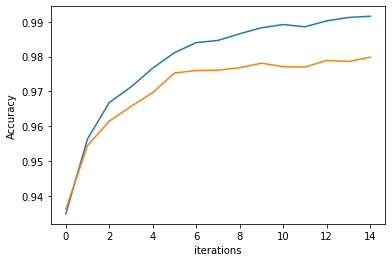

Train Accuracy: 0.99
Test Accuracy:0.98


In [88]:
## Plotting chart of training and testing accuracy as a function of iterations
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))